# Code for Oil Price Prediction (Daily WTI Oil Prices)

In [1]:
# Function to import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
Importing plotly failed. Interactive plots will not work.


In [2]:
# Function to display entire data graph
def show_graph(train, test=None, pred=None, title=None):
    
    fig = plt.figure(figsize=(20, 5))

    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Price')
    ax1.plot(train.index, train['Price'], color='green', label='Train price')
    if test is not None:
        ax1.plot(test.index, test['Price'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax1.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted price')
            ax1.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax1.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax1.legend()
    if title is not None:
        plt.title(title + ' (Entire)')
    plt.grid(True)

# Function to display recent data graph
    period=50
    period=int(0.2*len(train))
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Dates')
    ax2.set_ylabel('Price')
    ax2.plot(train.index[-period:], train['Price'].tail(period), color='green', label='Train Oil Price')
    if test is not None:
        ax2.plot(test.index, test['Price'], color='red', label='Test Oil Price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax2.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted price')
            ax2.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax2.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax2.legend()
    if title is not None:
        plt.title(title + ' (Recent ' + str(period) + ')')
    plt.grid(True)

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

# Function to calculate accuracy of the model
def calculate_accuracy(forecast, actual, algorithm):
    mse  = round(mean_squared_error(actual, forecast),4)
    mae  = round(mean_absolute_error(actual, forecast),4)
    rmse = round(sqrt(mean_squared_error(actual, forecast)),4)
    return ({'algorithm':algorithm, 'mse':mse, 'mae':mae, 'rmse': rmse})

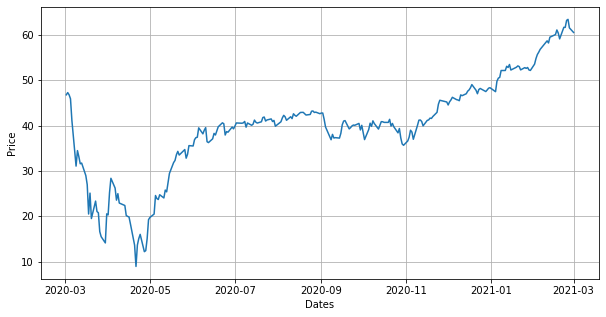

In [3]:
# Function to load data set
def get_data_from_EIA_local():
    df = pd.read_csv("C:/Users/komalj/Downloads/Dataset/Cushing_OK_WTI_Spot_Price_FOB.csv", header=4, parse_dates=[0])
    df.columns=["Date", "Price"]
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

df_org=get_data_from_EIA_local()
data=df_org['2020-03-01':'2021-03-01'].copy()
data.Price["2020-04-20"]=(data.Price["2020-04-17"] + data.Price["2020-04-21"]) / 2

acc_sum=[]
df_preds=pd.DataFrame({"Date":make_future_dates('2021-03-01',34)})
df_preds=df_preds.set_index('Date', drop=True)

plt.figure(figsize=(10,5))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(data['Price']);
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


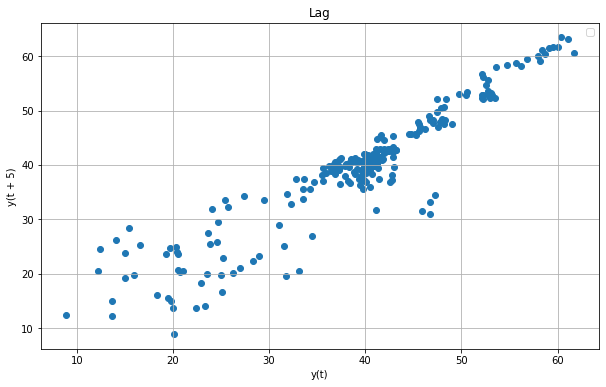

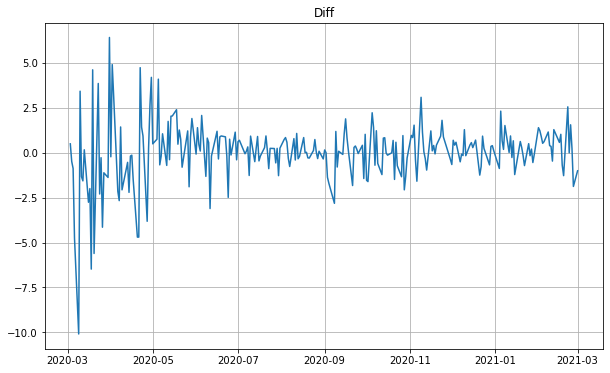

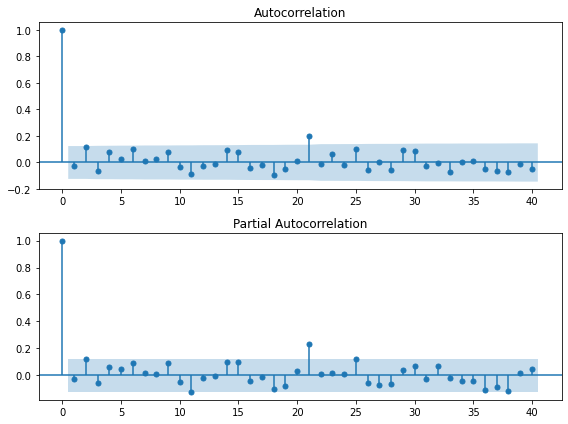

In [4]:
# Function to display LAG
fig = plt.figure(figsize=(10, 6))
lag_plot(data['Price'], lag=5)
plt.title('Lag')
plt.grid(True)
plt.legend();

# Function to display Diff
data_diff = data - data.shift() 
data_diff = data_diff.dropna()
plt.figure(figsize=(10, 6))
plt.title('Diff')
plt.grid(True)
plt.plot(data_diff);

fig = plt.figure(figsize=(8, 6))

# Function to display ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(data_diff, lags=40, ax=ax1)

# Function to display PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(data_diff, lags=40, ax=ax2)

plt.tight_layout()

<Figure size 1152x720 with 0 Axes>

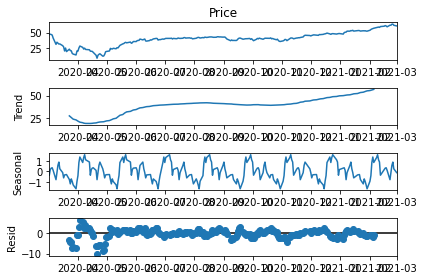

In [5]:
# Function to display seasonal decompose
result = seasonal_decompose(data.Price[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,10))
fig = result.plot()
plt.show()

In [6]:
values = DataFrame(data['Price'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.947279  0.869767  0.596535  0.987794
t+1   0.947279  1.000000  0.926910  0.661699  0.933116
t+5   0.869767  0.926910  1.000000  0.715768  0.852934
t+10  0.596535  0.661699  0.715768  1.000000  0.580825
t+30  0.987794  0.933116  0.852934  0.580825  1.000000


In [7]:
# Function to display ADF test results
adf_result = sm.tsa.stattools.adfuller(data['Price'].values, autolag ='AIC')
adf = pd.Series(adf_result[0:4], index = ['Test Statistic', 
                                          'p-　　value', '#Lags Used', 
                                          'Number of Observations Used'])
print(adf)

Test Statistic                  -0.567673
p-　　value                        0.878121
#Lags Used                       0.000000
Number of Observations Used    250.000000
dtype: float64


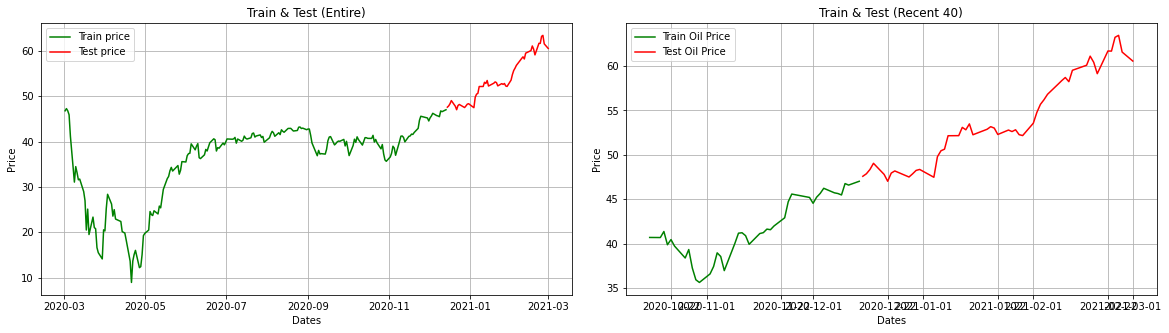

In [8]:
# Function to split data
split = int(0.80*len(data))
train_data, test_data = data[0:split], data[split:]
show_graph(train_data,test_data,title='Train & Test')

In [9]:
# Modelling

def evaluate_arima_model(train, test, order, maxlags=8, ic='aic'):
    # feature Scaling
    stdsc = StandardScaler()
    train_std = stdsc.fit_transform(train.values.reshape(-1, 1))
    test_std = stdsc.transform(test.values.reshape(-1, 1))
    # prepare training dataset
    history = [x for x in train_std]
    # make predictions
    predictions = list()
    # rolling forecasts
    for t in range(len(test_std)):
        # predict
        model = ARIMA(history, order=order)
        model_fit = model.fit(maxlags=maxlags, ic=ic, disp=0)
        yhat = model_fit.forecast()[0]
        # invert transformed prediction
        predictions.append(yhat)
        # observation
        history.append(test_std[t])
    # inverse transform
    predictions = stdsc.inverse_transform(np.array(predictions).reshape((-1)))
    # calculate mse
    mse = mean_squared_error(test, predictions)
    return predictions, mse

def evaluate_arima_models(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))
    for order in pdq:
        try:
            predictions, mse = evaluate_arima_model(train, test, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
            print('Model(%s) mse=%.3f' % (order,mse))
        except:
            continue
    print('Best Model(%s) mse=%.3f' % (best_cfg, best_score)) 
    return best_cfg

def predict_arima_model(train, period, order, maxlags=8, ic='aic'):
    # Feature Scaling
    stdsc = StandardScaler()
    train_std = stdsc.fit_transform(train.values.reshape(-1, 1))
    # fit model
    model = ARIMA(train_std, order=order)
    model_fit = model.fit(maxlags=maxlags, ic=ic, disp=0)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + period -1, typ='levels')
    # inverse transform
    yhat = stdsc.inverse_transform(np.array(yhat).flatten())
    return yhat

{'algorithm': 'AR Model', 'mse': 0.9665, 'mae': 0.8026, 'rmse': 0.9831}


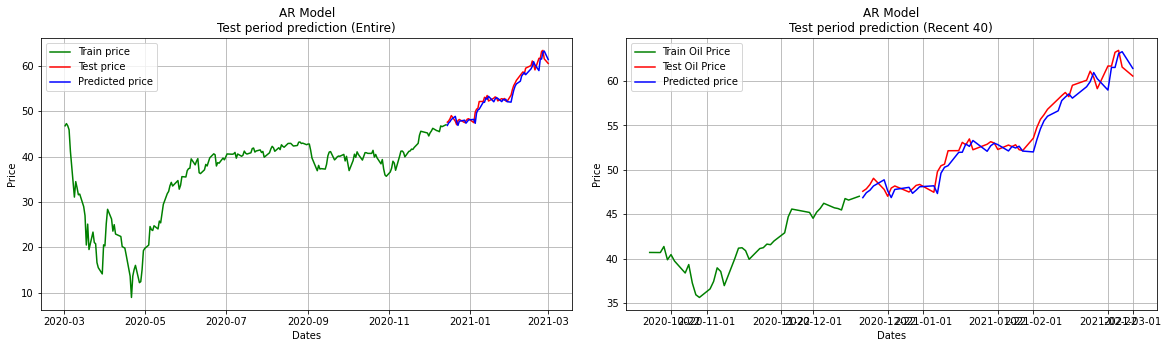

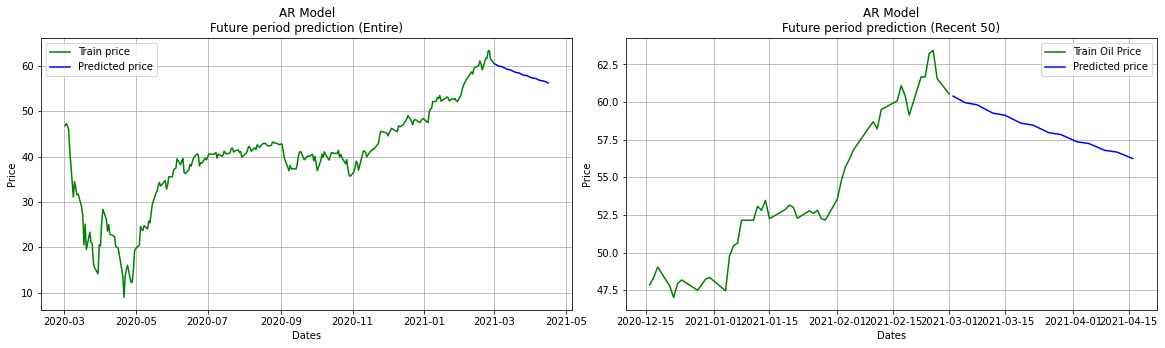

In [10]:
model_name='AR Model'

# evaluate parameters
p_values = range(1, 4)
d_values = [0]
q_values = [0]
#evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# Function to predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(1, 0, 0))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# Function to calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# Function to show result
show_graph(train_data,test_data,df_pred,title=model_name+'\nTest period prediction')

# Function to predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(1, 0, 0))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# Function to show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

{'algorithm': 'MA Model', 'mse': 82.7596, 'mae': 8.8296, 'rmse': 9.0972}


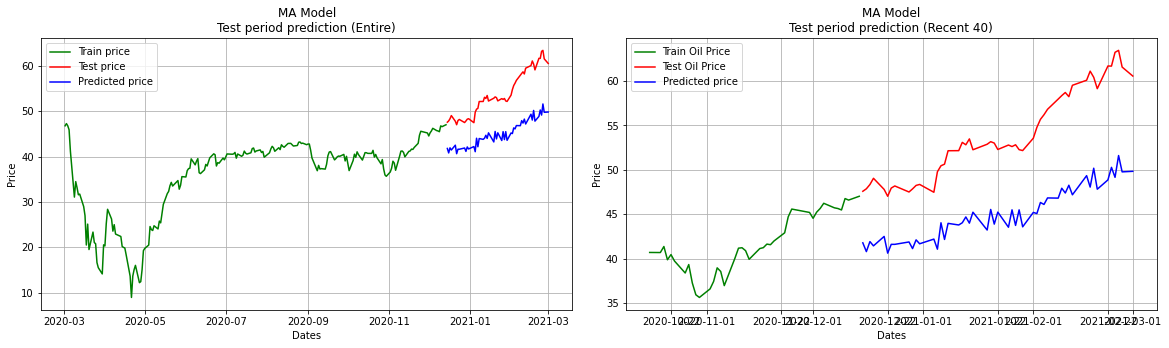

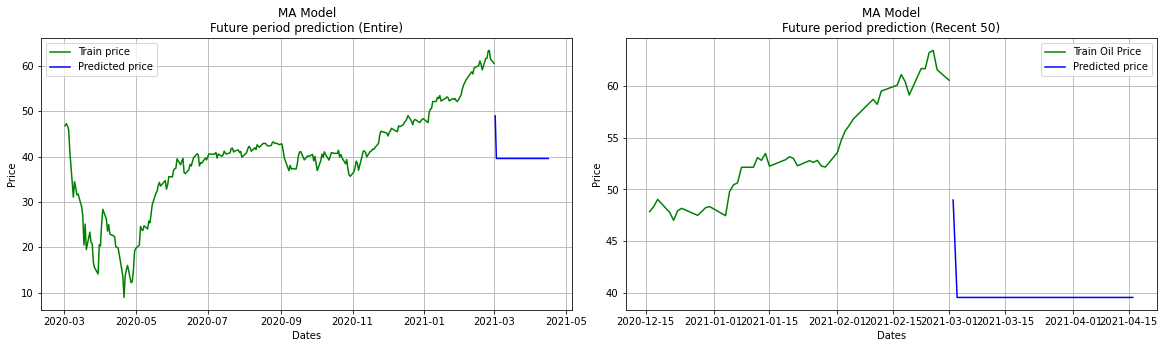

In [11]:
model_name='MA Model'

# evaluate parameters
p_values = [0]
d_values = [0]
q_values = range(1, 4)
#evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# Function to predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(0, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# Function to calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# Function to show result
show_graph(train_data, test_data, df_pred, title=model_name + '\nTest period prediction')

# Function to predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(0, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# Function to show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

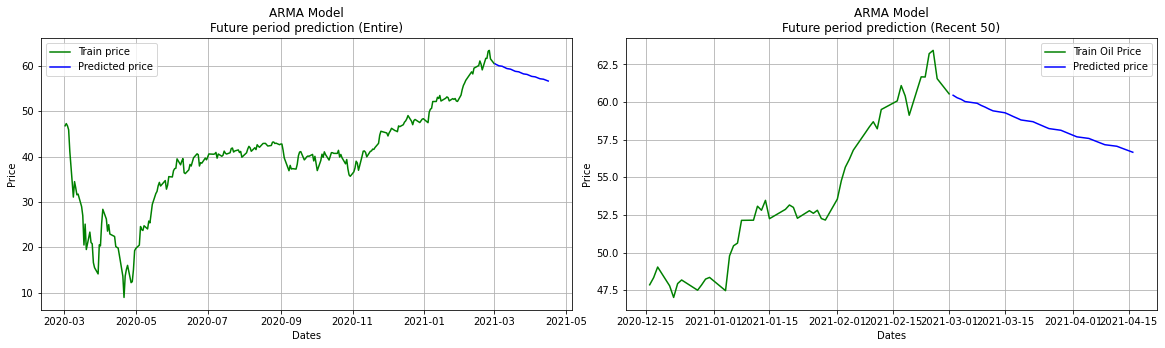

In [12]:
model_name='ARMA Model'

# Function to evaluate parameters
p_values = range(0, 1, 2)
d_values = [0]
q_values = range(0, 1, 2)
#evaluate_arima_models(train_data['Price'].tail, test_data['Price'], p_values, d_values, q_values)

# Function to predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(2, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# Function to show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

{'algorithm': 'ARIMA Model', 'mse': 0.8669, 'mae': 0.733, 'rmse': 0.9311}


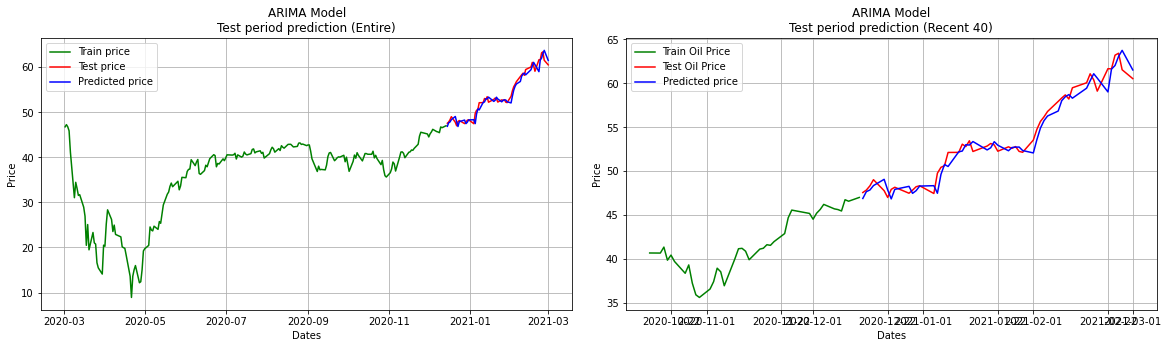

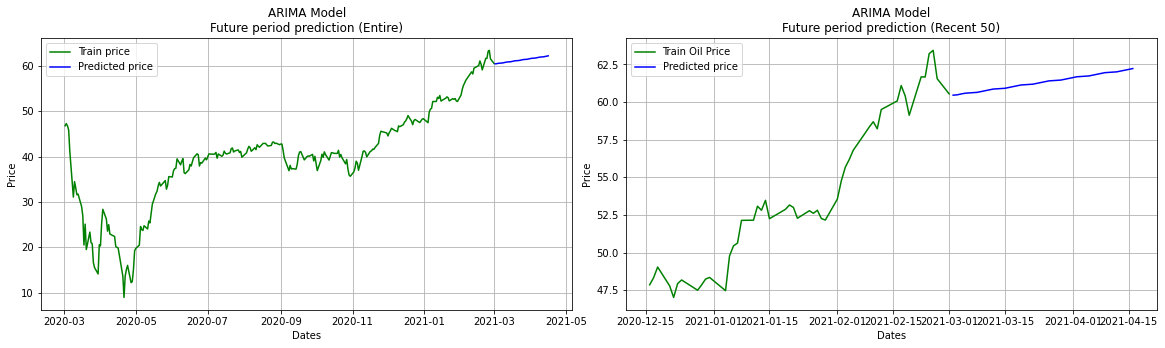

In [13]:
model_name='ARIMA Model'

# Function to evaluate parameters
p_values = [1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(1, 3)
# Function to evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# Function to predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(2, 1, 1))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# Function to calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'],model_name)
print(acc)
acc_sum.append(acc)

# Function to show result
show_graph(train_data, test_data, df_pred, title=model_name + '\nTest period prediction')

# Function to predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(2, 1, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# Function to show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'algorithm': 'Facebook Prophet', 'mse': 8.9671, 'mae': 2.2636, 'rmse': 2.9945}


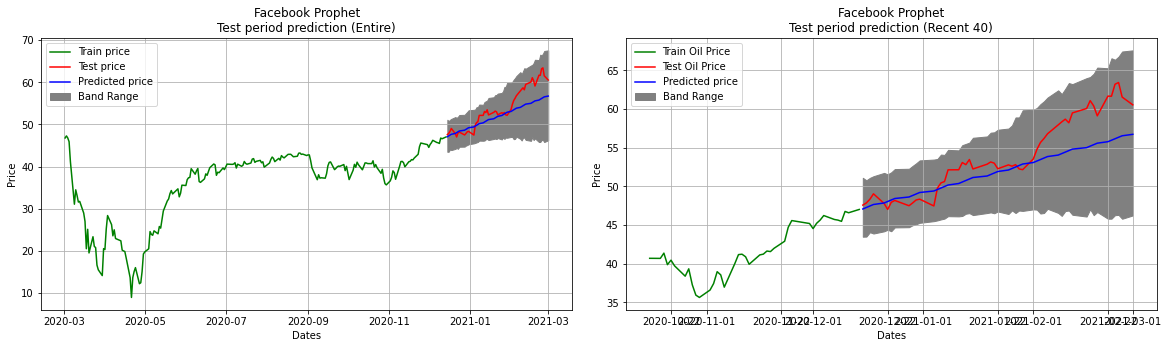

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


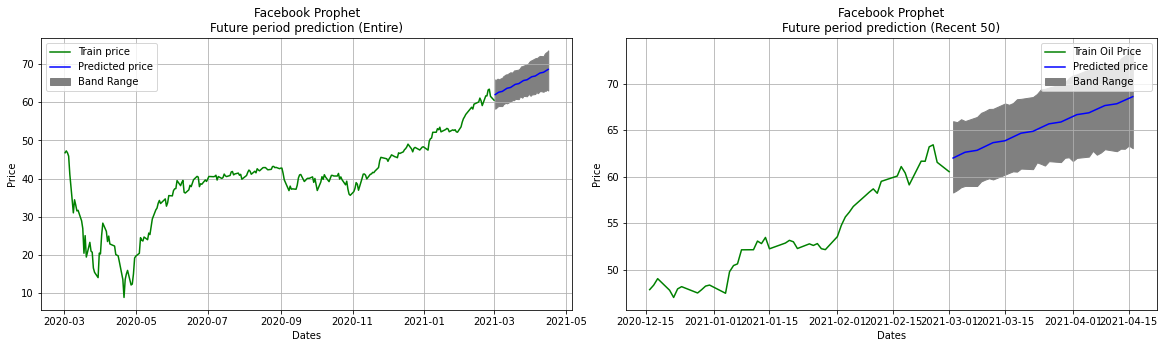

In [14]:
# Prophet Model

model_name='Facebook Prophet'

def predict_prophet(train,period):
    # create model
    prop = Prophet(growth='logistic',
                    n_changepoints=40,
                    changepoint_range=1,
                    changepoint_prior_scale=0.5,
                    weekly_seasonality=False,
                    yearly_seasonality=False
                  )
    # Function to prepare training dataset
    ph_df_train = pd.DataFrame({'y':train['Price'].values, 'ds':train.index})
    ph_df_train['cap'] = 100
    ph_df_train['floor'] = 0
    prop.fit(ph_df_train)
    # Function to create future dates
    future_prices = prop.make_future_dataframe(periods=period, freq = 'd')
    future_prices['cap'] = 100
    future_prices['floor'] = 0
    # Function to predict prices
    forecast = prop.predict(future_prices)
    predicted=forecast[-period:]
    return predicted

# Function to predict test period
predictions = predict_prophet(train_data,len(test_data))
predictions.index = test_data.index

# Function to calculate performance metrics
acc = calculate_accuracy(predictions['yhat'], test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# Function to show result
show_graph(train_data, test_data, predictions, title=model_name + '\nTest period prediction')

# Function to predict future period
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_prophet(data,len(future_dates))
predictions.index = future_dates

# Function to show result
show_graph(data,None,predictions,title=model_name+'\nFuture period prediction')

df_preds[model_name] = predictions['yhat']

In [15]:
# Function to evaluate performace metrics
df_sum = pd.DataFrame(acc_sum)
df_sum = df_sum.sort_values('mae', ascending=True)
df_sum = df_sum.reset_index(drop=True)
df_sum

,algorithm,mse,mae,rmse
0,ARIMA Model,0.8669,0.7330,0.9311
1,AR Model,0.9665,0.8026,0.9831
2,Facebook Prophet,8.9671,2.2636,2.9945
3,MA Model,82.7596,8.8296,9.0972


In [16]:
# Function to display forecasted prices
df_preds

,AR Model,MA Model,ARMA Model,ARIMA Model,Facebook Prophet
Date,,,,,
2021-03-02,60.391558,48.978562,60.447037,60.455521,62.007840
2021-03-03,60.244605,39.575219,60.282930,60.474472,62.216119
2021-03-04,60.099128,39.575219,60.178642,60.533794,62.423949
2021-03-05,59.955110,39.575219,60.028078,60.582082,62.631321
2021-03-08,59.812537,39.575219,59.917151,60.640519,62.838231
2021-03-09,59.671395,39.575219,59.776255,60.692333,63.044671
2021-03-10,59.531669,39.575219,59.661749,60.748775,63.250635
2021-03-11,59.393345,39.575219,59.527965,60.802031,63.456117
2021-03-12,59.256410,39.575219,59.411872,60.857488,63.661109


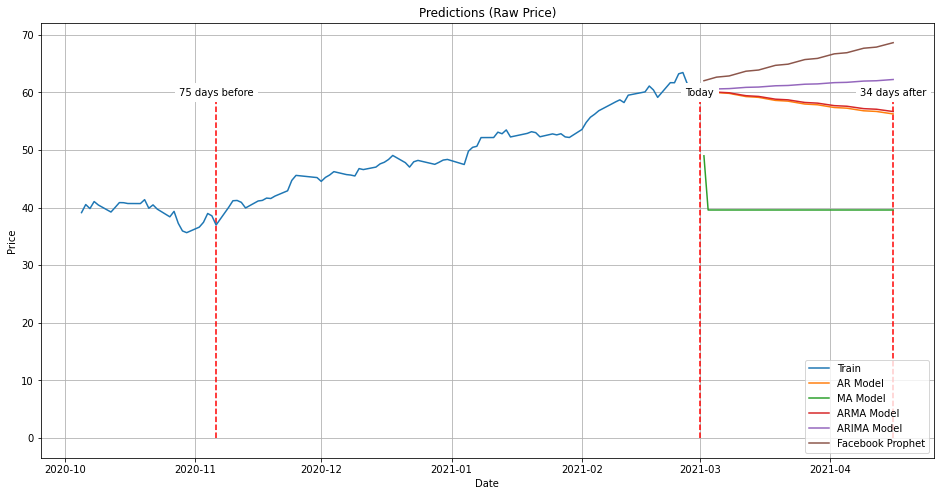

In [17]:
# Function to display forecasted results
plt.figure(figsize=(16, 8))
plt.plot(data.index[-100:], data['Price'].tail(100),label="Train")
for col in df_preds.columns:
    plt.plot(df_preds.index[-len(df_preds):], df_preds[col][-len(df_preds):],label=col)
    
plt.vlines([data.index[-1]], 0, 60, "red", linestyles='dashed')
plt.text([data.index[-1]], 60, 'Today', backgroundcolor='white', ha='center', va='center')
plt.vlines([data.index[-1-75]], 0, 60, "red", linestyles='dashed')
plt.text([data.index[-1-75]], 60, '75 days before', backgroundcolor='white', ha='center', va='center')
plt.vlines([df_preds.index[-1]], 0, 60, "red", linestyles='dashed')
plt.text([df_preds.index[-1]], 60, '34 days after', backgroundcolor='white', ha='center', va='center')
plt.title('Predictions (Raw Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='lower right',ncol=1)
plt.grid(True)
plt.show()